In [69]:
#from scipy.special import expit as sigmoid, logit as inverse_sigmoid #Extracting individual predicted values
from sklearn.metrics import accuracy_score
import geopandas as gpd
from xgboost import XGBClassifier
from collections import Counter 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import cv
import xgboost as xgb
import os
import shap #Explainable model

#Define the path
path=os.getcwd()
print("Done Loading...")

Done Loading...


## All Models Log Loss Evaluation Metrics

In [2]:
import plotly
import kaleido
import plotly.express as px
import plotly.graph_objects as go


df1 = pd.read_excel("logloss.xlsx")
df2 = df1.iloc[:,1:]
colors = [ 'red', 'blue', 'green']

fig = go.Figure()
for i, col in enumerate(df2):
    fig.add_traces(go.Scatter(x=df1.Model, y = df2[col].values,
                              mode = 'markers',
                              name = col,
                              marker=dict(color=colors[i])))
fig.update_traces(marker_size=15)

fig.update_layout( scattergap=0.75,
    plot_bgcolor = "white")

fig.update_layout(title={
    'text': "<b>Evaluation Metrics for AIV Models </b>",
    'y':0.78,
    'x':0.45,
    'xanchor': 'center',
    'yanchor': 'top'})#,
    #width=650, height=400)
fig.update_xaxes(title_text='Model', showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(title_text='Logloss', showline=True, linewidth=2, linecolor='black', mirror=True)
fig.write_image("mlogloss_all_models.png", width=600, height=350, scale=2)
print("\nDone......\n")


Done......



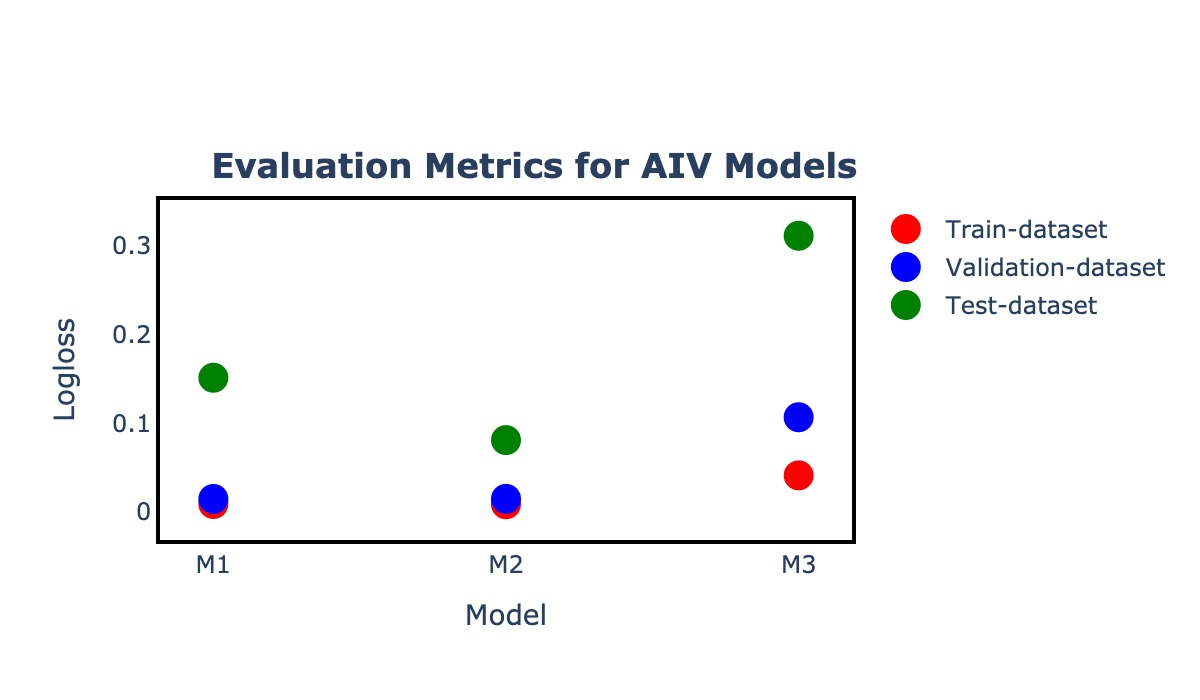

In [3]:
#View the Image inline
from IPython.display import Image
img_bytes = fig.to_image(format="jpg", width=600, height=350, scale=2,  engine="kaleido")
Image(img_bytes)


# Model one SHAP Analysis   (No Wild birds used as features)

In [2]:
#Load the model
bst1 = xgb.Booster({'nthread': 4}) #init model
bst1.load_model('model1_sorted_data/model1xgb_poltry.json')

In [21]:
#Load Train and Test files
train_df = pd.read_excel("model1_sorted_data/m1train_sorted.xlsx")
test_df = pd.read_csv("model1_sorted_data/m1test_poultry_filled.csv")
X_train = train_df.iloc[:,6:] #Training
y_train = train_df.iloc[:,5:6]


#Test
X_test = test_df.iloc[:,6:]
X_test_raw = test_df.iloc[:,5:6]
y_test = test_df.iloc[:,6:]
y_test_raw = test_df.iloc[:,6:]

print("\nDone Loading Data Files.........\n")


Done Loading Data Files.........



In [27]:
test_df.iloc[:,5]

0       0
1       0
2       0
3       0
4       0
       ..
1196    1
1197    1
1198    1
1199    1
1200    1
Name: label, Length: 1201, dtype: int64

In [6]:
#Run SHAP model
explainer = shap.TreeExplainer(bst1)
shap_values = explainer.shap_values(X_train)

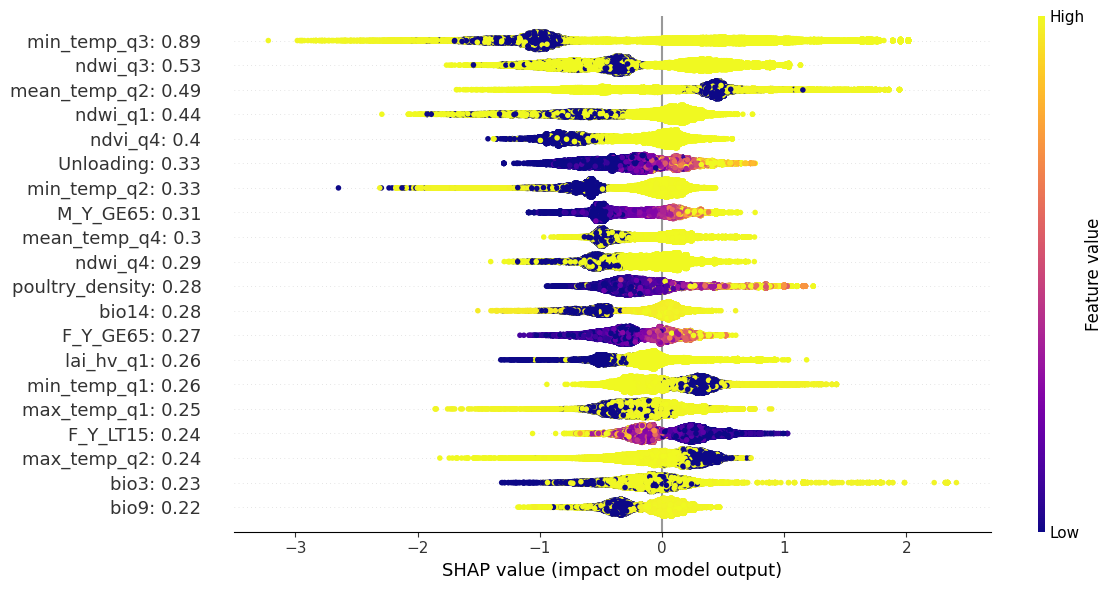

In [8]:

#print(shap_values)
feature_names = [a + ": " + str(b) for a,b in zip(X_train.columns, np.abs(shap_values).mean(0).round(2))]
shap.summary_plot(shap_values, 
                  features=X_train, 
                #cmap = plt.get_cmap("summer"),
                  cmap = plt.get_cmap("plasma"),
                  feature_names=feature_names,
                  show=False
                )
plt.gcf().set_size_inches(12,6)
plt.tight_layout()
plt.savefig('model1_sorted_data/model1_beeswarm_shap.png', dpi=500)
plt.show()

In [6]:
def global_class_contribution(model, X, name):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    print("Model Name....", name)
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    feature_importance.sort_values(by=['importance'], ascending=False, inplace=True)
    return feature_importance.to_excel("{}_class_contribution.xlsx".format(name), index=True)
#global_class_contribution(bst1, X_train, "bst1")
print("\nDone Processing......\n")


Done Processing......



####  M1 Bar Plot


 Done Processing....



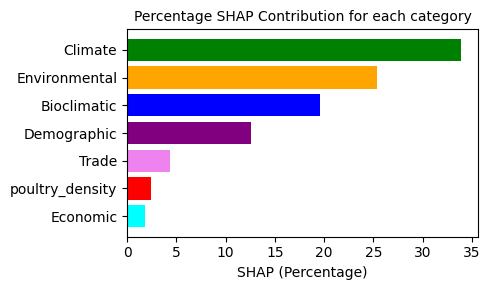

In [5]:
df = pd.read_excel("model1_bargraph.xlsx")
x = df["Variables"]
y = df["Percentage"]
color=["green", "orange", "blue", "purple", "violet", "red","aqua"]
plt.figure(figsize=(5,3))
plt.title("Percentage SHAP Contribution for each category", fontsize=10)
plt.xlabel("SHAP (Percentage)")
#plt.ylabel("Feature Category")
revcolor = color[::-1]
plt.barh(x,y, color=revcolor)
plt.tight_layout()
plt.savefig("model1_sorted_data/model1_shapCat.png", dpi=500)

print("\n Done Processing....\n")

### Class Contribution

# Model Two SHAP Analysis  (Wild Birds used as features)

In [4]:
#Load M2 Retuned Model
bst2_retuned = xgb.Booster({'nthread': 4}) #init model
bst2_retuned.load_model('model2_sorted_data/train/model2xgb_with_poultry.json')
print("Successfully loaded the models.....")

Successfully loaded the models.....


In [5]:
#Load Train and Test Excel files
train_df2 = pd.read_excel("model2_sorted_data/m2train_poultry_file.xlsx")
test_df2 = pd.read_csv("model2_sorted_data/m2test_poultry_filled.csv")
X_train2 = train_df2.iloc[:,6:] #Training
y_train2 = train_df2.iloc[:,5:6]

X_test2 = test_df2.iloc[:,6:]
X_test2_mat = xgb.DMatrix(X_test2)
X_test_raw2 = test_df2.iloc[:,6:]
y_test2 = test_df2.iloc[:,5:6]
y_test_raw2 = test_df2.iloc[:,5:6]

print("Finished Loading data....")


Finished Loading data....


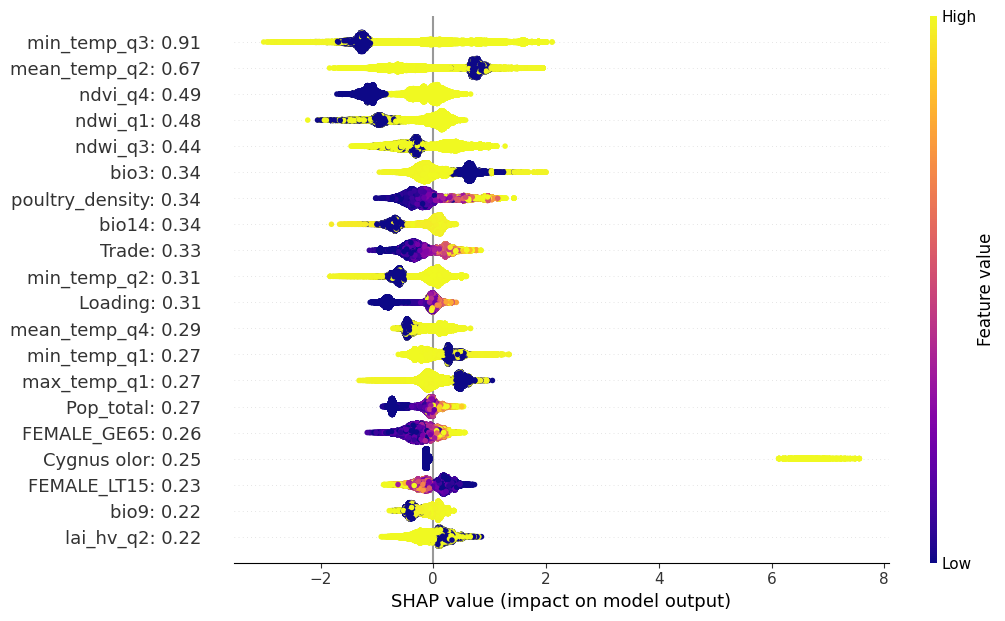

In [6]:
#Retuned New Model
explainer = shap.TreeExplainer(bst2_retuned)
shap_values2 = explainer.shap_values(X_train2)
#print(shap_values)
feature_names = [a + ": " + str(b) for a,b in zip(X_train2.columns, np.abs(shap_values2).mean(0).round(2))]
shap.summary_plot(shap_values2, 
                  features=X_train2, 
                #cmap = plt.get_cmap("summer"),
                  cmap = plt.get_cmap("plasma"),
                  feature_names=feature_names,
                  show=False
                )
plt.gcf().set_size_inches(12,6)
plt.savefig('model2_sorted_data/model2_beeswarm_shap.png', dpi=500)
plt.show()

## Mapping SHAP values back to Features with +ve imapact

In [50]:
shap_values_df = pd.DataFrame(shap_values2, columns=X_train2.columns)

shap_values_df["Region"] = train_df2["Region"]
shap_values_df["Year"] = train_df2["Year"]
#shap_values_df

In [104]:
# Filter rows with positive impact for the feature "Feature_A"
positive_impact_indices_gt1 = shap_values_df[shap_values_df["poultry_density"] > 0.5].index
#positive_impact_indices_gt1 = shap_values_df[shap_values_df["poultry_density"] > 1].index
positive_impact_indices_gt1

Index([  435,   437,   438,   439,   450,   841,   853,   961,   962,   963,
       ...
       37170, 37171, 37174, 37175, 37176, 37538, 37541, 37542, 37544, 37555],
      dtype='int64', length=4128)

In [105]:
# Get the data points from training data where "Feature_A" has a positive impact
positive_impact_data_gt1 = X_train2.iloc[positive_impact_indices_gt1]

In [106]:
#positive_impact_data_gt1

In [107]:
matched_data = train_df2.loc[positive_impact_indices_gt1]
matched_data.to_csv("model2_sorted_data/poultry_density_high_shap.csv", index=True)

In [116]:
matched_data

,Region,Year,HPAI_LPAI,species,subtype,label,poultry_density,max_temp_q1,max_temp_q2,max_temp_q3,...,Uria aalge,Alcidae (incognita),Cepphus grylle,Fratercula arctica,Vanellus vanellus,Sterna hirundo,Thalasseus sandvicensis,Cygnus bewickii,Stercorarius skua,Pyrrhula pyrrhula
435,DE941,2006,-999,-999,-999,0,513125,-999.000000,-999.000000,-999.000000,...,0,0,0,0,0,0,0,0,0,0
437,DE943,2006,-999,-999,-999,0,513125,-999.000000,-999.000000,-999.000000,...,0,0,0,0,0,0,0,0,0,0
438,DE944,2006,-999,-999,-999,0,513125,-999.000000,-999.000000,-999.000000,...,0,0,0,0,0,0,0,0,0,0
439,DE945,2006,-999,-999,-999,0,513125,-999.000000,-999.000000,-999.000000,...,0,0,0,0,0,0,0,0,0,0
450,DE94G,2006,-999,-999,-999,0,513125,8.528709,18.334354,27.874193,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37538,UKN01,2021,-999,-999,-999,0,206574,-999.000000,-999.000000,-999.000000,...,0,0,0,0,0,0,0,0,0,0
37541,UKN04,2021,-999,-999,-999,0,206574,-999.000000,-999.000000,-999.000000,...,0,0,0,0,0,0,0,0,0,0
37542,UKN05,2021,-999,-999,-999,0,206574,-999.000000,-999.000000,-999.000000,...,0,0,0,0,0,0,0,0,0,0
37544,UKN08,2021,-999,-999,-999,0,206574,8.791097,14.116129,21.550580,...,0,0,0,0,0,0,0,0,0,0


### Plot the data in SHape file

In [134]:
grouped_df = matched_data.groupby(['Region', 'Year', 'HPAI_LPAI', 'species', 'subtype', 'poultry_density'], as_index=False).agg({'label': 'sum'})
grouped_df = grouped_df[grouped_df.label >=1 ]
grouped_df.poultry_density.min()

117435

In [119]:
#import shape file and select NUTS_3 refion
shape = "/Users/michaelrogo/software/cli_he_code/paper/nature_coms/plots/python/data/NUTS_RG_20M_2016_4326.shp"
countries = gpd.read_file(shape)
nuts_3 = countries[countries['LEVL_CODE'] == 3]
#nuts_3

In [121]:
#Join SHape file and DF
poultry_density = pd.merge(
    left=nuts_3, 
    right=grouped_df,
    left_on='NUTS_ID',
    right_on='Region',
    how='left'
)
print("Finished merging....")
poultry_density.poultry_density.unique()

Finished merging....


array([    nan, 168345., 173640., 162700., 164995., 155815., 175405.,
       166580., 138463., 126027., 143818., 128210., 121813., 735640.,
       707360., 803333., 820480., 848760., 826047., 792200., 689930.,
       593224., 761390., 885510., 214258., 237706., 216357., 152310.,
       130961., 202934., 184708., 236305., 236445., 516318., 317148.,
       119160., 232608., 215200., 209398., 238410., 281893., 269150.,
       264903., 296960., 213705., 195325., 748763., 529573., 584370.,
       617060., 278520., 325160., 290610., 266860., 228570., 154620.,
       295130., 246475., 244927., 159440., 233115., 154617., 167829.,
       357403., 332225., 256693., 195810., 177485., 140680., 147130.,
       143090., 244115., 207418., 224590., 157680., 158233., 508813.,
       606663., 582200., 557738., 117435., 147230., 187250., 151800.,
       149968., 475648., 441399., 468318., 470150., 484128., 248363.,
       234050., 238003., 241457., 251817., 264190., 147310., 149479.,
       151648., 1559

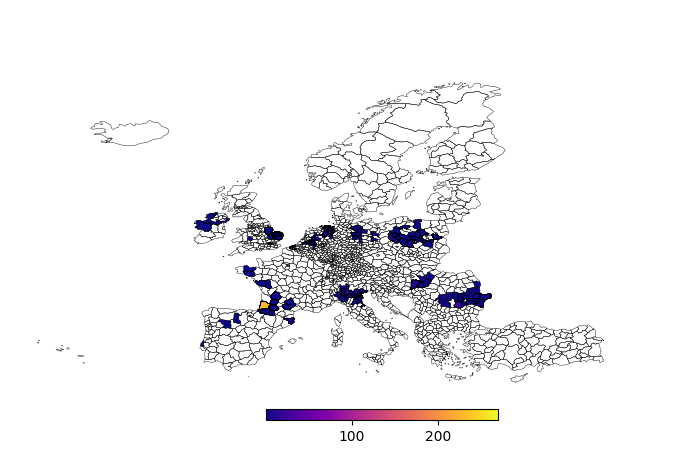

In [131]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

cm = 1/2.54

ax = poultry_density.boundary.plot(
    edgecolor='black',
    linewidth=0.3,
    figsize=(15, 14)
)
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", "12%", pad=0.9)

colors = [ "darkblue", "purple"] #, "orange", "gray"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

poultry_density.plot(ax=ax ,column='label',cmap="plasma", #cmap=cmap1)
                    legend=True,
                    #cax = cax,
                    legend_kwds={'shrink':0.2, 'fraction':0.45, 
                                 'orientation':'horizontal',
                                'pad': 0.2, 'anchor': (0.54, 1.41)})

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_ylim(34, 80)
ax.set_xlim(-35, 55)

#legend_dict = { 'Positive outbreaks' : 'purple', 'Negative outbreaks' : 'darkblue'} # 'False Positives' : 'orange', 'False Negatives' : 'gray' }
# patchList = []
# for key in legend_dict:
#         data_key = mpatches.Patch(color=legend_dict[key], label=key)
#         patchList.append(data_key)

# plt.legend(handles=patchList, loc='upper right', bbox_to_anchor=(0.9, 0.5))

for edge in ['right', 'bottom','top','left']:
      ax.spines[edge].set_visible(False)
#ax.set_title('2021 test data for AIV distribution in Europe', y=0.81)
plt.savefig('model2_sorted_data/poultry_density_predicted_regions.png', dpi=500)
plt.show()

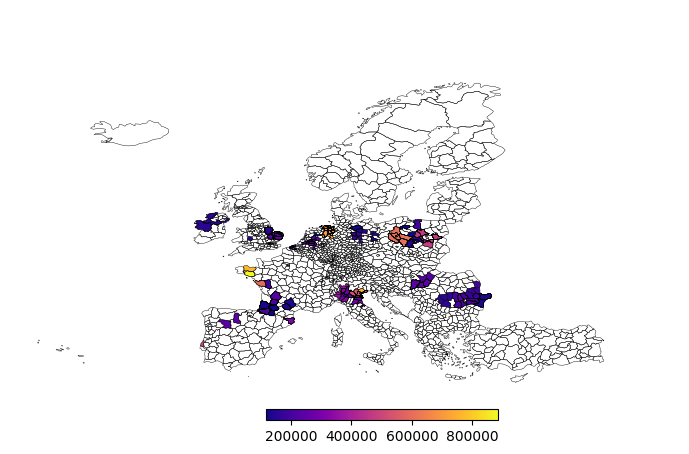

In [132]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

cm = 1/2.54

ax = poultry_density.boundary.plot(
    edgecolor='black',
    linewidth=0.3,
    figsize=(15, 14)
)
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", "12%", pad=0.9)

colors = [ "darkblue", "purple"] #, "orange", "gray"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

poultry_density.plot(ax=ax ,column='poultry_density',cmap="plasma", #cmap=cmap1)
                    legend=True,
                    #cax = cax,
                    legend_kwds={'shrink':0.2, 'fraction':0.45, 
                                 'orientation':'horizontal',
                                'pad': 0.2, 'anchor': (0.54, 1.41)})

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_ylim(34, 80)
ax.set_xlim(-35, 55)

#legend_dict = { 'Positive outbreaks' : 'purple', 'Negative outbreaks' : 'darkblue'} # 'False Positives' : 'orange', 'False Negatives' : 'gray' }
# patchList = []
# for key in legend_dict:
#         data_key = mpatches.Patch(color=legend_dict[key], label=key)
#         patchList.append(data_key)

# plt.legend(handles=patchList, loc='upper right', bbox_to_anchor=(0.9, 0.5))

for edge in ['right', 'bottom','top','left']:
      ax.spines[edge].set_visible(False)
#ax.set_title('2021 test data for AIV distribution in Europe', y=0.81)
plt.savefig('model2_sorted_data/poultry_density_positive_impact_model.png', dpi=500)
plt.show()

### Class Contribution

In [7]:

global_class_contribution(bst2_retuned, X_train2, "bst2")
print("\nDone Processing....")

Model Name.... bst2

Done Processing....


#### M2 Bar Plot


Done processing....



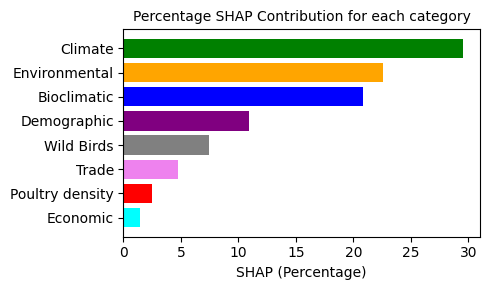

In [8]:
df = pd.read_excel("model2_bargraph.xlsx")
x = df["Variables"]
y = df["Percentage"]
color=["green", "orange", "blue", "purple", "gray", "violet", "red","aqua"]
revcolor = color[::-1]
plt.figure(figsize=(5,3))
plt.title("Percentage SHAP Contribution for each category",fontsize=10)
plt.xlabel("SHAP (Percentage)")
#plt.ylabel("Feature Category")
plt.barh(x,y, color=revcolor)
#plt.savefig("model2_bargraph.png")
plt.tight_layout()
plt.savefig("model2_sorted_data/model2_shapCat.png", dpi=500)
print("\nDone processing....\n")

# Model Three (Wild Bird Labels switched off)

In [11]:
#Load M3
bst3 = xgb.Booster({'nthread': 4}) #init model
bst3.load_model('model3_sorted_data/train/modelxgb1.model')
print("Successfully loaded the models.....")

Successfully loaded the models.....


In [12]:
#Load Train and Test Excel files
train_df3 = pd.read_excel("model3_sorted_data/train/m3train_no_lpai.xlsx")
test_df3 = pd.read_excel("model3_sorted_data/train/m3test.xlsx")
X_train3 = train_df3.iloc[:,6:] #Training
y_train3 = train_df3.iloc[:,5:6]

#Test 
X_test3 = test_df3.iloc[:,6:]
X_test_raw3 = test_df3.iloc[:,6:]
y_test3 = test_df3.iloc[:,5:6]
y_test_raw3 = test_df3.iloc[:,5:6]

print("Finished Loading data...")

Finished Loading data...


In [22]:
train_df3.head()

,Region,Year,HPAI_LPAI,species,subtype,label,poultry_density,max_temp_q1,max_temp_q2,max_temp_q3,...,Uria aalge,Alcidae (incognita),Cepphus grylle,Fratercula arctica,Vanellus vanellus,Sterna hirundo,Thalasseus sandvicensis,Cygnus bewickii,Stercorarius skua,Pyrrhula pyrrhula
0,AL011,2006,-999,-999,-999,0,0,8.764677,19.652742,25.863468,...,0,0,0,0,0,0,0,0,0,0
1,AL012,2006,-999,-999,-999,0,0,-999.000000,-999.000000,-999.000000,...,0,0,0,0,0,0,0,0,0,0
2,AL013,2006,-999,-999,-999,0,0,6.686613,18.338387,24.337822,...,0,0,0,0,0,0,0,0,0,0
3,AL014,2006,-999,-999,-999,0,0,11.325645,22.615564,29.519193,...,0,0,0,0,0,0,0,0,0,0
4,AL015,2006,-999,-999,-999,0,0,9.695419,21.285612,28.166128,...,0,0,0,0,0,0,0,0,0,0


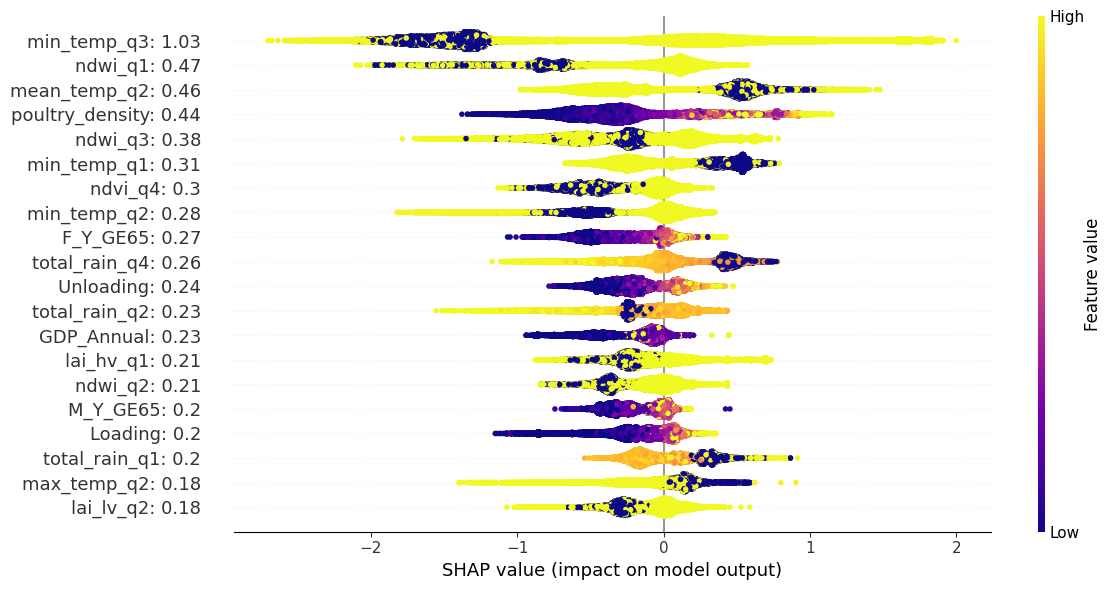

In [13]:
### Class Contribution
explainer = shap.TreeExplainer(bst3)
shap_values3x = explainer(X_train3)
shap_values3 = explainer.shap_values(X_train3)
#print(shap_values)
feature_names = [a + ": " + str(b) for a,b in zip(X_train3.columns, np.abs(shap_values3).mean(0).round(2))]
shap.summary_plot(shap_values3, 
                  features=X_train3, 
                #cmap = plt.get_cmap("summer"),
                  cmap = plt.get_cmap("plasma"),
                  feature_names=feature_names,
                  show=False
                )
plt.gcf().set_size_inches(12,6)
plt.tight_layout()
plt.savefig('model3_sorted_data/model3_beeswarm_shap.png', dpi=500)
plt.show()

### Class Contribution

In [33]:
# def global_shap_importance(model, X, name):
#     """ Return a dataframe containing the features sorted by Shap importance
#     Parameters
#     ----------
#     model : The tree-based model 
#     X : pd.Dataframe
#          training set/test set/the whole dataset ... (without the label)
#     Returns
#     -------
#     pd.Dataframe
#         A dataframe containing the features sorted by Shap importance
#     """
#     print(name)
#     explainer = shap.Explainer(model)
#     shap_values = explainer(X)
#     cohorts = {"": shap_values}
#     cohort_labels = list(cohorts.keys())
#     cohort_exps = list(cohorts.values())
#     for i in range(len(cohort_exps)):
#         if len(cohort_exps[i].shape) == 2:
#             cohort_exps[i] = cohort_exps[i].abs.mean(0)
#     features = cohort_exps[0].data
#     feature_names = cohort_exps[0].feature_names
#     values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
#     feature_importance = pd.DataFrame(list(zip(feature_names, sum(values))), columns=['features', 'importance'])
#     feature_importance.sort_values(by=['importance'], ascending=False, inplace=True)
#     return feature_importance.to_excel("{}_feature_importance.xlsx".format(name))
# #print(path)

In [12]:
global_class_contribution(bst3, X_train3, "bst3")
print("\nDone Processing...\n")

Model Name.... bst3

Done Processing...




Done Processing...



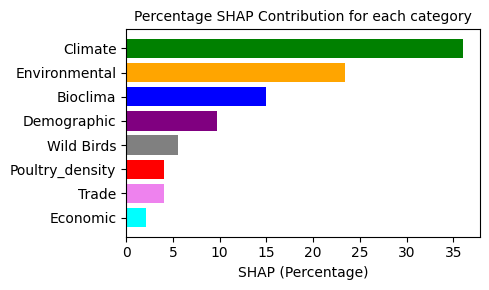

In [19]:
df = pd.read_excel("model3_bargraph.xlsx")
x = df["Variables"]
y = df["Percentage"]
color=["green", "orange", "blue", "purple", "gray", "red","violet", "aqua"]
#color=["green","orange",  "blue", "violet", "purple", "gray", "red", "aqua"]
revcolor = color[::-1]
plt.figure(figsize=(5,3))
plt.title("Percentage SHAP Contribution for each category", fontsize = 10)
plt.xlabel("SHAP (Percentage)")
#plt.ylabel("Feature Category")
plt.barh(x,y, color=revcolor)
plt.tight_layout()
plt.savefig("model3_sorted_data/model3_shapCat.png", dpi=500)
print("\nDone Processing...\n")

In [58]:
global_shap_importance(bst3_sub, X_sub_train3, "bst3_sub")
print("\nDone Processing...\n")

bst3_sub

Done Processing...



In [ ]:
shap.plots.force(explainer.expected_value, shap_values2)

/Users/michaelrogo/pip_installs/lib/python3.12/site-packages/shap/plots/_force.py:208: UserWarning: shap.plots.force is slow for many thousands of rows, try subsampling your data.
  warnings.warn("shap.plots.force is slow for many thousands of rows, try subsampling your data.")


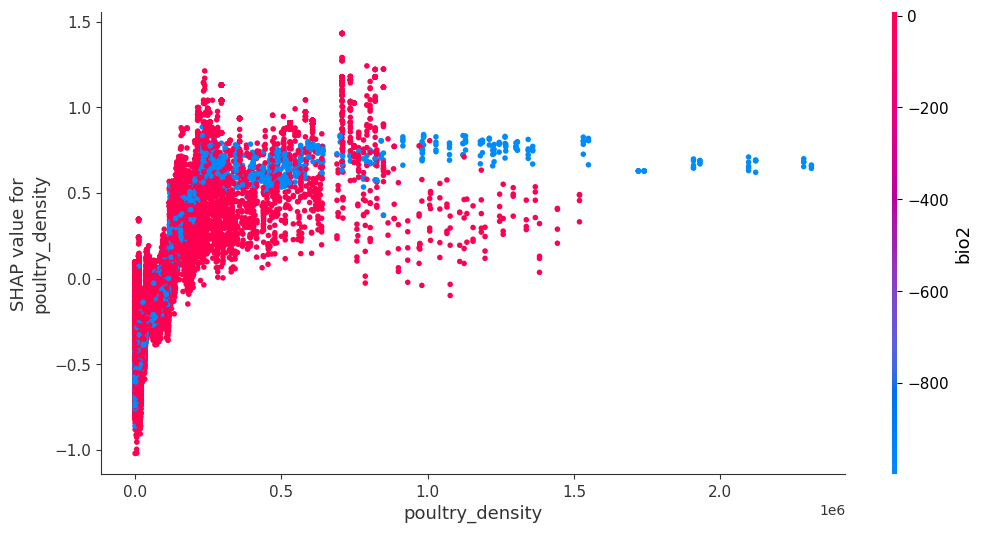

In [155]:
fig, ax = plt.subplots(figsize=(12,6))

# Generate the SHAP dependence plot
shap.dependence_plot("poultry_density", shap_values2, X_train2, ax=ax)

# Save the plot

fig.savefig('model2_sorted_data/mdel2_dependence_bio13.png', format='png', dpi=500)

# Display the plot
plt.show()